In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [19]:
dire = "../Compare_optimisers/"
sgd_phy_loss = np.load(dire + "SGD_const_lr/" + "phy_loss.npy")
sgd_math_loss = np.load(dire + "SGD_const_lr/" + "math_loss.npy")

In [4]:
adam_phy_loss = np.load(dire + "Adam/" + "phy_loss.npy")
adam_math_loss = np.load(dire + "Adam/" + "math_loss.npy")

In [16]:
cma_phy_loss = np.load(dire + "CMA_5_200/" + "phy_loss.npy")
cma_math_loss = np.load(dire + "CMA_5_200/" + "math_loss.npy")

In [23]:
cmasgd_phy_loss = np.load(dire + "CMA_SGD_larger/" + "phy_loss.npy")
cmasgd_math_loss = np.load(dire + "CMA_SGD_larger/" + "math_loss.npy")

In [29]:
cmals_phy_loss = np.load(dire + "CMA_LINE/" + "phy_loss_plot.npy")
cmals_math_loss = np.load(dire + "CMA_LINE/" + "math_loss_plot.npy")

Text(0, 0.5, 'physical loss')

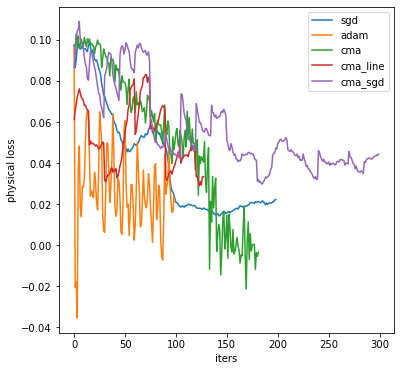

In [30]:
fig = plt.figure(figsize=(6,6))
plt.plot(sgd_phy_loss, label="sgd")
plt.plot(adam_phy_loss, label="adam")
plt.plot(cma_phy_loss, label="cma")
plt.plot(cmals_phy_loss,label="cma_line")
plt.plot(cmasgd_phy_loss[:300], label="cma_sgd")
plt.legend()
plt.xlabel('iters')
plt.ylabel("physical loss")

I use physical loss to represent the loss caused by **drag** and **bounding space regulization**, 
Physical loss is what we concern, but not differentiable with respect to latent space, so we have to calculate the gradient of math loss.


Math loss represents the **assembled inflow loss** plus the **latent space regulization**,
Math loss is used for backpropogation. I used the snippets of Minimal DeepSDF at bottom to illustate physical and math loss.



Some conclusions so far: CMA-ES line search doesn't decrease the physical loss. It only decreases the math loss slowly.
CMA-SGD behaves like SGD and output similar optimised car shape.
SGD is probably the best optimiser so far.

Some difficulties so far: Since the physical loss is what we concern, but math lass is used usually for calculating gradient. I don't know choose which one for pure CMA-ES. Because CMA-ES has to evaluate the function value of objective function. Which loss should represents the our objective function value. I am not sure how to choose it. Another strange thing is that math loss doesn't decrease in any case of optimisers, but physical loss successfully decrease. This is hard to imagine for me.

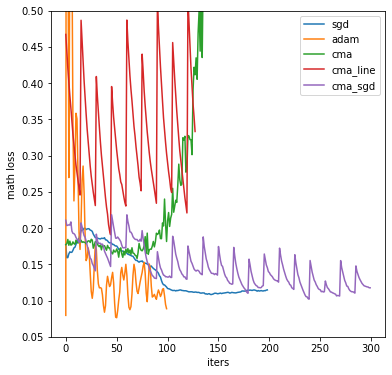

In [31]:
fig = plt.figure(figsize=(6,6))
plt.plot(sgd_math_loss)
plt.plot(adam_math_loss)
plt.plot(cma_math_loss)
plt.plot(cmals_math_loss)
plt.plot(cmasgd_math_loss[:300])
plt.ylim([0.05, 0.5])
plt.xlabel('iters')
plt.ylabel("math loss")
plt.legend(["sgd", "adam", "cma", "cma_line", "cma_sgd"])

remark: 
the  backward loss is very small compared to regulization.





In [ ]:

# compute loss function: Chamfer between current guess (xyz_upstream) and objective (xyz_target)
physical_loss = chamfer_distance(xyz_upstream, xyz_target)
print("Loss at iter", e, ":", loss.item(), ", latent norm: ", torch.norm(latent) )
losses.append(loss.detach().cpu().numpy())                                  ## Loss value
#np.save(os.path.join(optimization_meshes_dir, "log.npy"), losses)
lambdas.append(torch.norm(latent_target-latent).detach().cpu().numpy())     ## Distance in the domain
#np.save(os.path.join(optimization_meshes_dir, "lambda.npy"), lambdas)
# now store upstream gradients
loss.backward()

dL_dx_i = xyz_upstream.grad


optimizer.zero_grad()
# use vertices to compute full backward pass
xyz = torch.tensor(verts.astype(float), requires_grad = True, dtype=torch.float32)#, device=torch.device('cuda:0')) # For GPU,
latent_inputs = latent.expand(xyz.shape[0], -1)
inputs = torch.cat([latent_inputs, xyz], 1)#.cuda()      #Add .cuda() if you want to run on GPU
#first compute normals
pred_sdf = decoder(inputs)
loss_normals = torch.sum(pred_sdf)
loss_normals.backward(retain_graph = True)
normals = xyz.grad/torch.norm(xyz.grad, 2, 1).unsqueeze(-1)


# now assemble inflow derivative
optimizer.zero_grad()
dL_ds_i_fast = -torch.matmul(dL_dx_i.unsqueeze(1), normals.unsqueeze(-1)).squeeze(-1)
math_loss = torch.sum(dL_ds_i_fast * pred_sdf)
math_loss += regl2* torch.mean(latent.pow(2))